In [29]:
# Importing required libariries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
# Muting the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module = 'sklearn')

In [4]:
# Loading the dataset from raw_data.csv into the dataframe

data = pd.read_csv('../datasets/raw_data.csv', sep=',')
data = data.rename(columns={'human_development_index':'hdi'})
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50418 entries, 0 to 50417
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   iso_code          50418 non-null  object 
 1   location          50418 non-null  object 
 2   date              50418 non-null  object 
 3   total_cases       47324 non-null  float64
 4   total_deaths      39228 non-null  float64
 5   stringency_index  43292 non-null  float64
 6   population        50418 non-null  int64  
 7   gdp_per_capita    44706 non-null  float64
 8   hdi               44216 non-null  float64
 9   Unnamed: 9        50418 non-null  object 
 10  Unnamed: 10       50418 non-null  object 
 11  Unnamed: 11       50418 non-null  object 
 12  Unnamed: 12       50418 non-null  float64
 13  Unnamed: 13       50418 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 5.4+ MB


In [5]:
print('The total number of records: '+str(len(data.index)))
print('Columns names: '+str(data.columns.tolist()))
print('Number of countries: '+str(len(data['location'].unique())))
print('Number of missing values: \n' + str(data.isnull().sum()))

The total number of records: 50418
Columns names: ['iso_code', 'location', 'date', 'total_cases', 'total_deaths', 'stringency_index', 'population', 'gdp_per_capita', 'hdi', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']
Number of countries: 210
Number of missing values: 
iso_code                0
location                0
date                    0
total_cases          3094
total_deaths        11190
stringency_index     7126
population              0
gdp_per_capita       5712
hdi                  6202
Unnamed: 9              0
Unnamed: 10             0
Unnamed: 11             0
Unnamed: 12             0
Unnamed: 13             0
dtype: int64


In [6]:
# Preparing the data by dropping unwanted columns 
data = data.drop(['iso_code', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'], axis = 1)

In [7]:
data = data.dropna(axis = 0)
data.isnull().sum()

location            0
date                0
total_cases         0
total_deaths        0
stringency_index    0
population          0
gdp_per_capita      0
hdi                 0
dtype: int64

In [8]:
len(data)

31518

/var/folders/k1/xs8bp_gn6hn0wy7np2cf0txc0000gn/T/ipykernel_91087/1365659389.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr(method='pearson')


<AxesSubplot: >

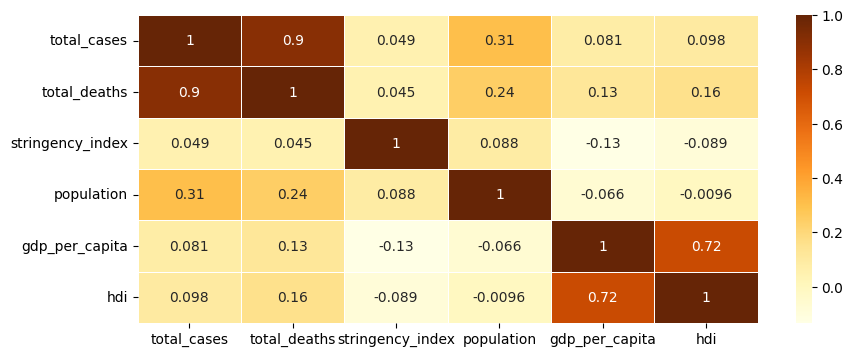

In [9]:
corr = data.corr(method='pearson')
fig = plt.subplots(figsize = (10, 4))
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='YlOrBr',
            annot=True,
            linewidth=0.5)

In [10]:
# Log - transfrom the skewed features

gdp_transformed = data['gdp_per_capita'].apply(lambda x: np.log(x+1))
total_deaths_transformed = data['total_deaths'].apply(lambda x: np.log(x+1))

Text(0, 0.5, 'Total Number of Deaths')

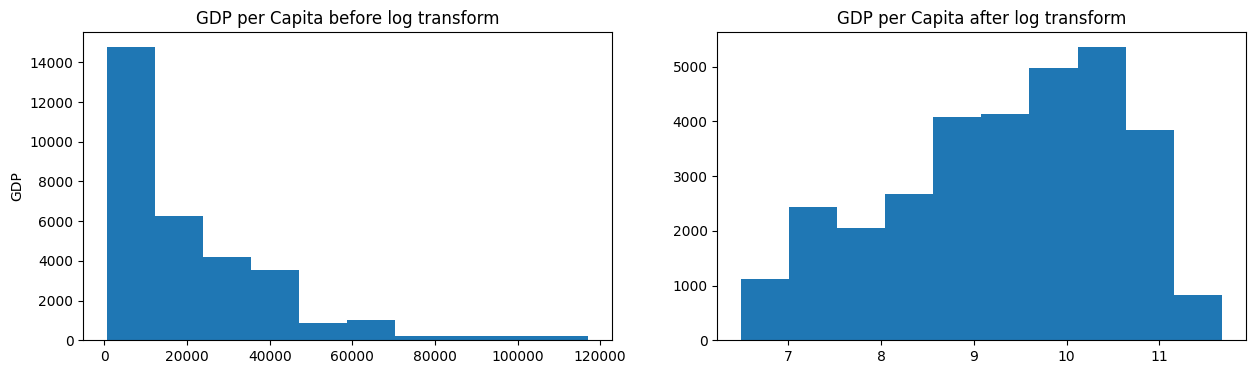

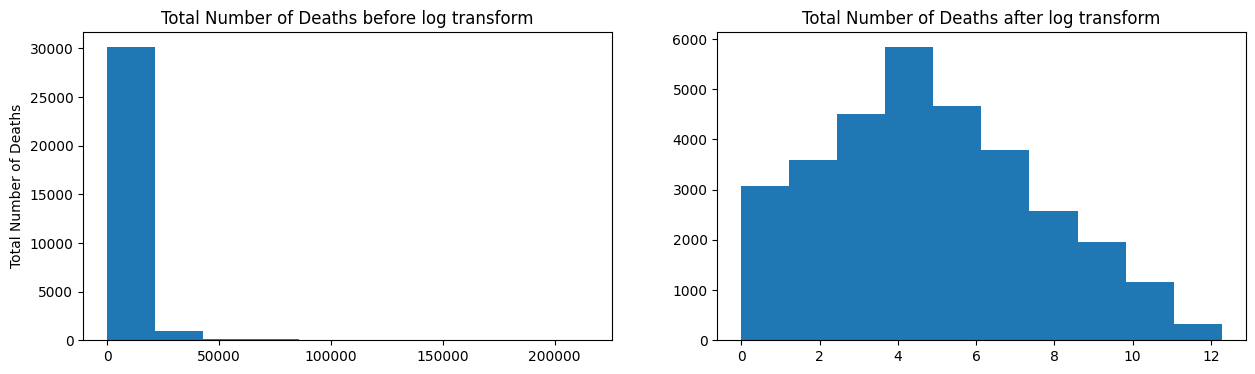

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))

ax1.hist(data['gdp_per_capita'])
ax2.hist(gdp_transformed)
ax1.set_title("GDP per Capita before log transform")
ax2.set_title("GDP per Capita after log transform")
ax1.set_ylabel("GDP")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))

ax1.hist(data['total_deaths'])
ax2.hist(total_deaths_transformed)
ax1.set_title("Total Number of Deaths before log transform")
ax2.set_title("Total Number of Deaths after log transform")
ax1.set_ylabel("Total Number of Deaths")

In [12]:
data['gdp_per_capita'] = gdp_transformed 
data['total_deaths'] = total_deaths_transformed
data.head()

,location,date,total_cases,total_deaths,stringency_index,population,gdp_per_capita,hdi
0,Afghanistan,2019-12-31,0.0,0.0,0.0,38928341,7.498309,0.498
1,Afghanistan,2020-01-01,0.0,0.0,0.0,38928341,7.498309,0.498
2,Afghanistan,2020-01-02,0.0,0.0,0.0,38928341,7.498309,0.498
3,Afghanistan,2020-01-03,0.0,0.0,0.0,38928341,7.498309,0.498
4,Afghanistan,2020-01-04,0.0,0.0,0.0,38928341,7.498309,0.498


In [13]:
scaler = MinMaxScaler()
numerical = ['total_deaths', 'gdp_per_capita']
features_log_minmax_transform = pd.DataFrame(data = data)
features_log_minmax_transform[numerical] = scaler.fit_transform(data[numerical])
features_log_minmax_transform

,location,date,total_cases,total_deaths,stringency_index,population,gdp_per_capita,hdi
0,Afghanistan,2019-12-31,0.0,0.000000,0.00,38928341,0.193801,0.498
1,Afghanistan,2020-01-01,0.0,0.000000,0.00,38928341,0.193801,0.498
2,Afghanistan,2020-01-02,0.0,0.000000,0.00,38928341,0.193801,0.498
3,Afghanistan,2020-01-03,0.0,0.000000,0.00,38928341,0.193801,0.498
4,Afghanistan,2020-01-04,0.0,0.000000,0.00,38928341,0.193801,0.498
...,...,...,...,...,...,...,...,...
50413,Zimbabwe,2020-10-15,8055.0,0.443642,76.85,14862927,0.203796,0.535
50414,Zimbabwe,2020-10-16,8075.0,0.443642,76.85,14862927,0.203796,0.535
50415,Zimbabwe,2020-10-17,8099.0,0.443642,76.85,14862927,0.203796,0.535
50416,Zimbabwe,2020-10-18,8110.0,0.443642,76.85,14862927,0.203796,0.535


In [14]:
from sklearn.model_selection import train_test_split

X_data =  features_log_minmax_transform[['total_cases','total_deaths','stringency_index','population','hdi']]
y_data = features_log_minmax_transform['gdp_per_capita']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 22062 samples.
Testing set has 9456 samples.


In [15]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [16]:
# vanilla regression and K-fold cross validation
s = StandardScaler()
lr = LinearRegression()

X_train_s = s.fit_transform(X_train)
lr.fit(X_train_s, y_train)
X_test = s.transform(X_test)  
y_pred = lr.predict(X_test)
score = r2_score(y_test.values, y_pred)

# with pipeline
estimator = Pipeline([("scaler", s),("regression", lr)])
predictions_lr = cross_val_predict(estimator, X_train, y_train, cv=kf)
linear_score = r2_score(y_train, predictions_lr)

linear_score, score #almost identical

(0.7996927742013762, 0.8002741740995302)

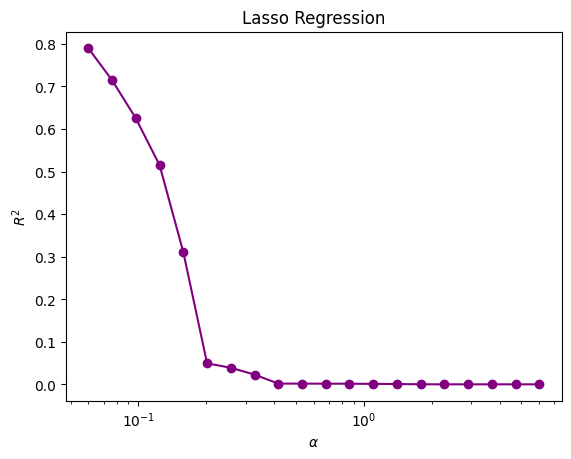

In [19]:
# lasso regression and K-fold cross validation
s = StandardScaler()
pf = PolynomialFeatures(degree=3)
kf = KFold(shuffle=True, random_state=72018, n_splits=3)
scores = []
alphas = np.geomspace(0.06, 6.0, 20)
predictions_lsr = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions_lsr = cross_val_predict(estimator, X_train, y_train, cv = kf)
    
    score = r2_score(y_train, predictions_lsr)
    
    scores.append(score)
plt.semilogx(alphas, scores, '-o', color='purple')
plt.title('Lasso Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [20]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X_train, y_train)
lasso_score = best_estimator.score(X_train, y_train)

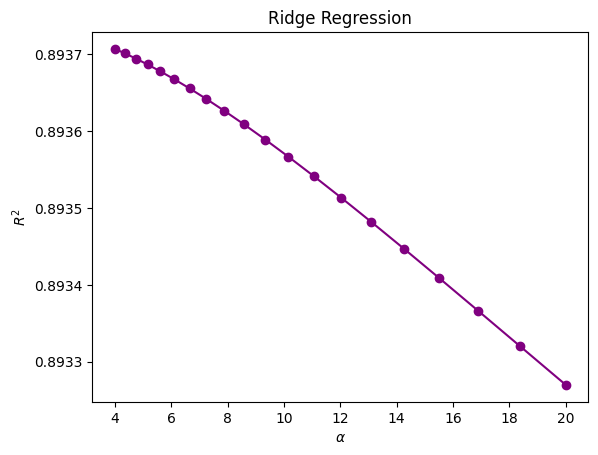

In [49]:
# ridge regression and K-fold cross validation
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
predictions_rr = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions_rr = cross_val_predict(estimator, X_train, y_train, cv = kf)
    score = r2_score(y_train, predictions_rr)
    scores.append(score)

plt.plot(alphas, scores, '-o', color='purple')
plt.title('Ridge Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [21]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("ridge_regression", Ridge(alpha=0.03))])

best_estimator.fit(X_train, y_train)
ridge_score = best_estimator.score(X_train, y_train)

In [22]:
# comparing scores
pd.DataFrame([[linear_score, lasso_score, ridge_score]],columns=['linear', 'lasso', 'ridge'], index=['score'])

,linear,lasso,ridge
score,0.799693,0.834543,0.893962


In [30]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

# Fit a basic linear regression model
linearRegression = LinearRegression().fit(X_train, y_train)
linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

# Fit a regular (non-cross validated) Ridge model
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
ridgeCV = RidgeCV(alphas=alphas, cv=4).fit(X_train, y_train)
ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

# Fit a Lasso model using cross validation and determine the optimum value for 𝛼
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2,
                  max_iter=int(5e4),
                  cv=3).fit(X_train, y_train)
lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

# Fit elastic net with the same set of alphas as lasso
l1_ratios = np.linspace(0.1, 0.9, 9)
elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=int(1e4)).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))


rmse_vals = [linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]

labels = ['Linear', 'Lasso', 'Ridge', 'ElasticNet']

rmse_df = pd.DataFrame([[linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]],columns=['Linear', 'Lasso', 'Ridge', 'ElasticNet'], index=['rmse'])
rmse_df

,Linear,Lasso,Ridge,ElasticNet
rmse,1.397796,1.397007,1.397331,1.397227


[Text(0.5, 0, 'Actual'),
 Text(0, 0.5, 'Predicted'),
 Text(0.5, 1.0, 'Linear Regression Results')]

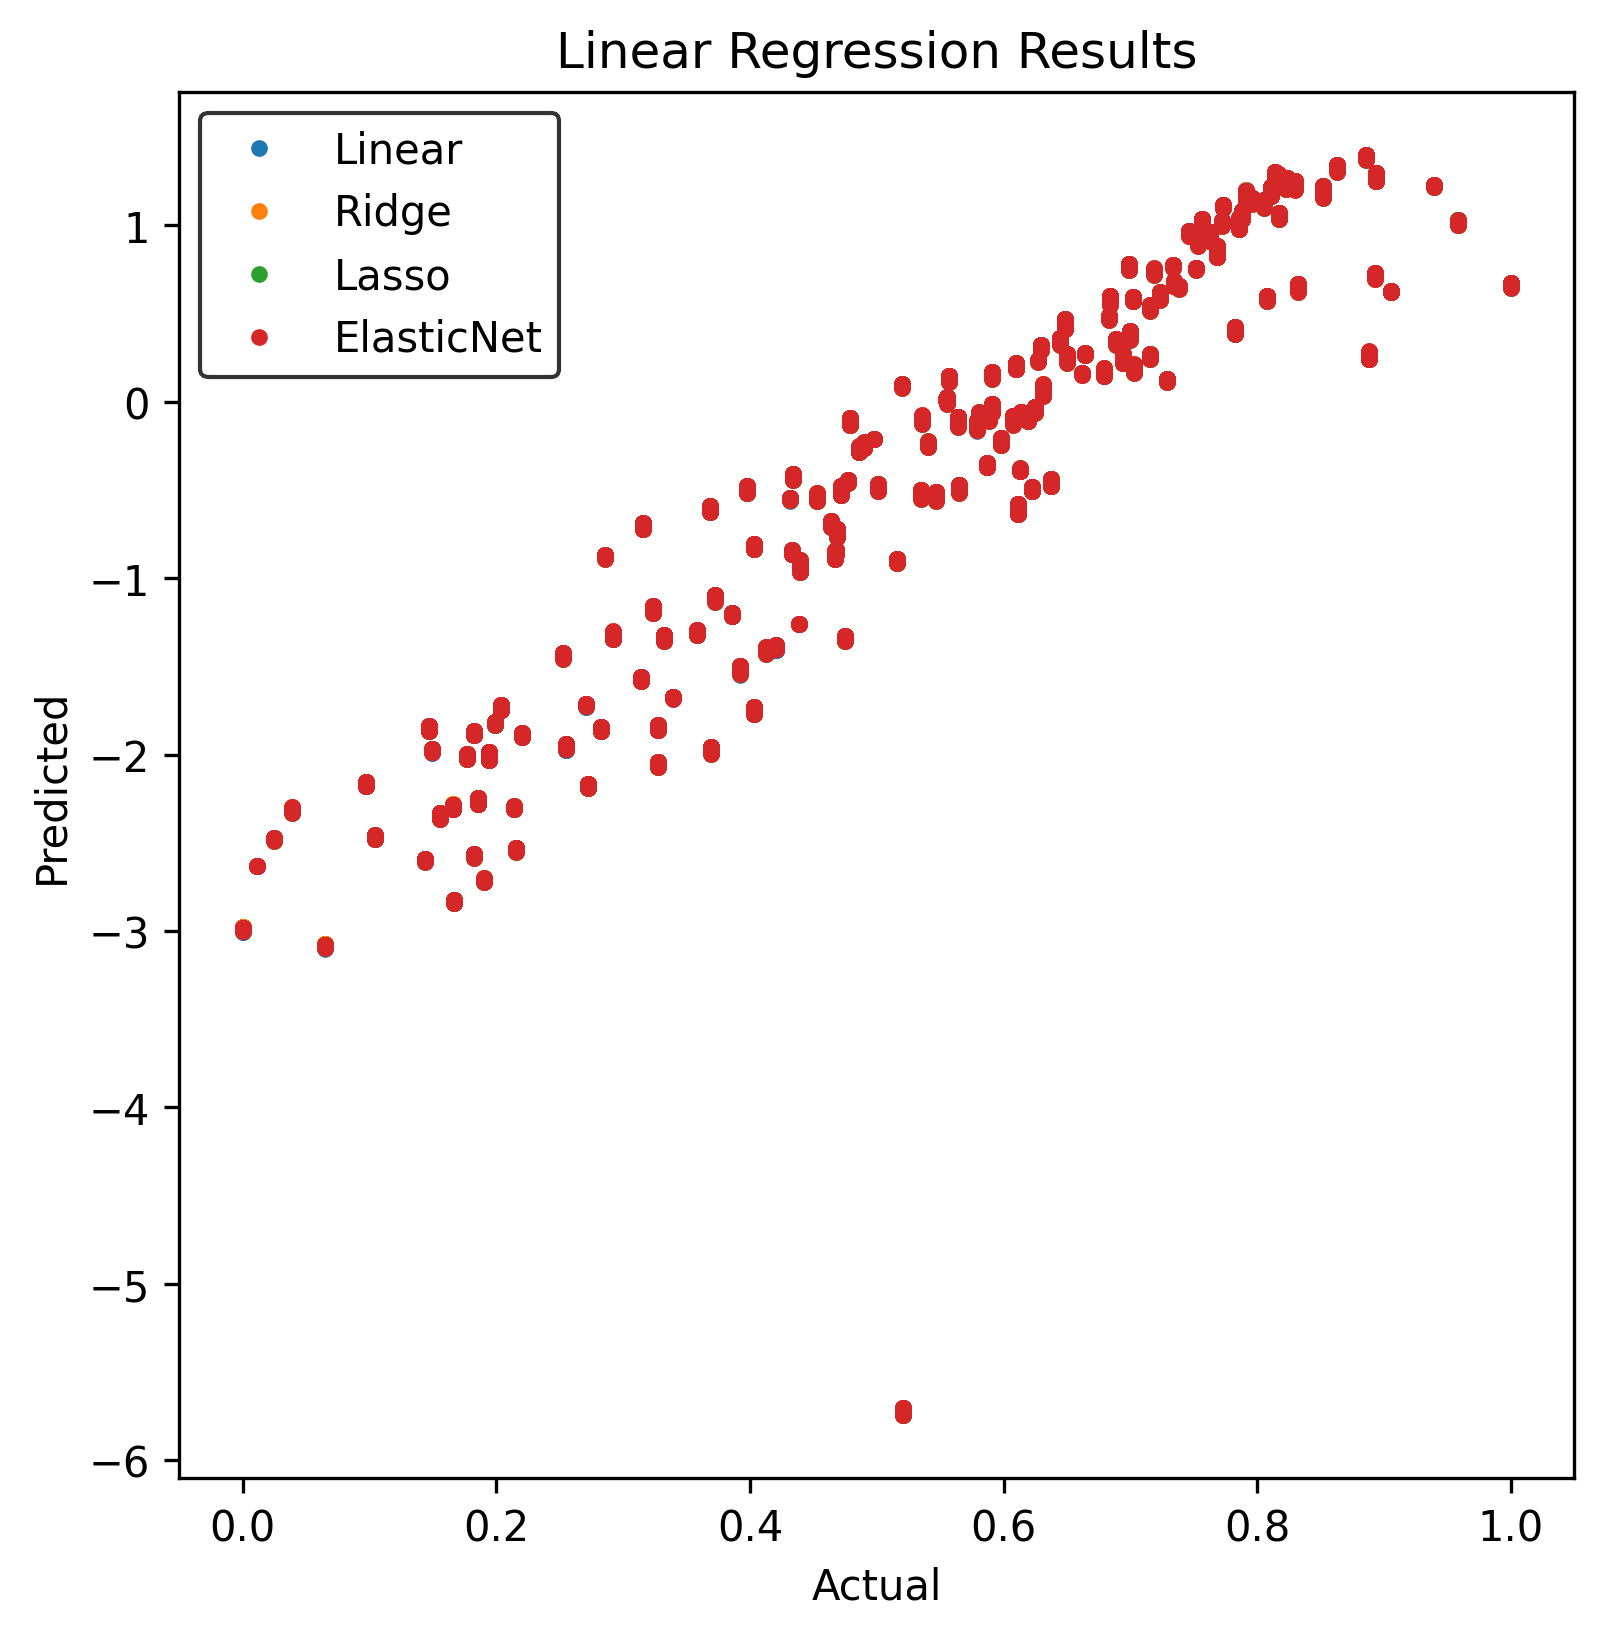

In [ ]:
f = plt.figure(figsize=(6,6), dpi=300)
ax = plt.axes()

labels, models = ['Linear', 'Ridge', 'Lasso', 'ElasticNet'], [linearRegression, ridgeCV, lassoCV, elasticNetCV]

for mod, label in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test), marker='o', ls='', ms=3.0, label=labels, alpha=1)
    
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual', ylabel='Predicted', title='Linear Regression Results')

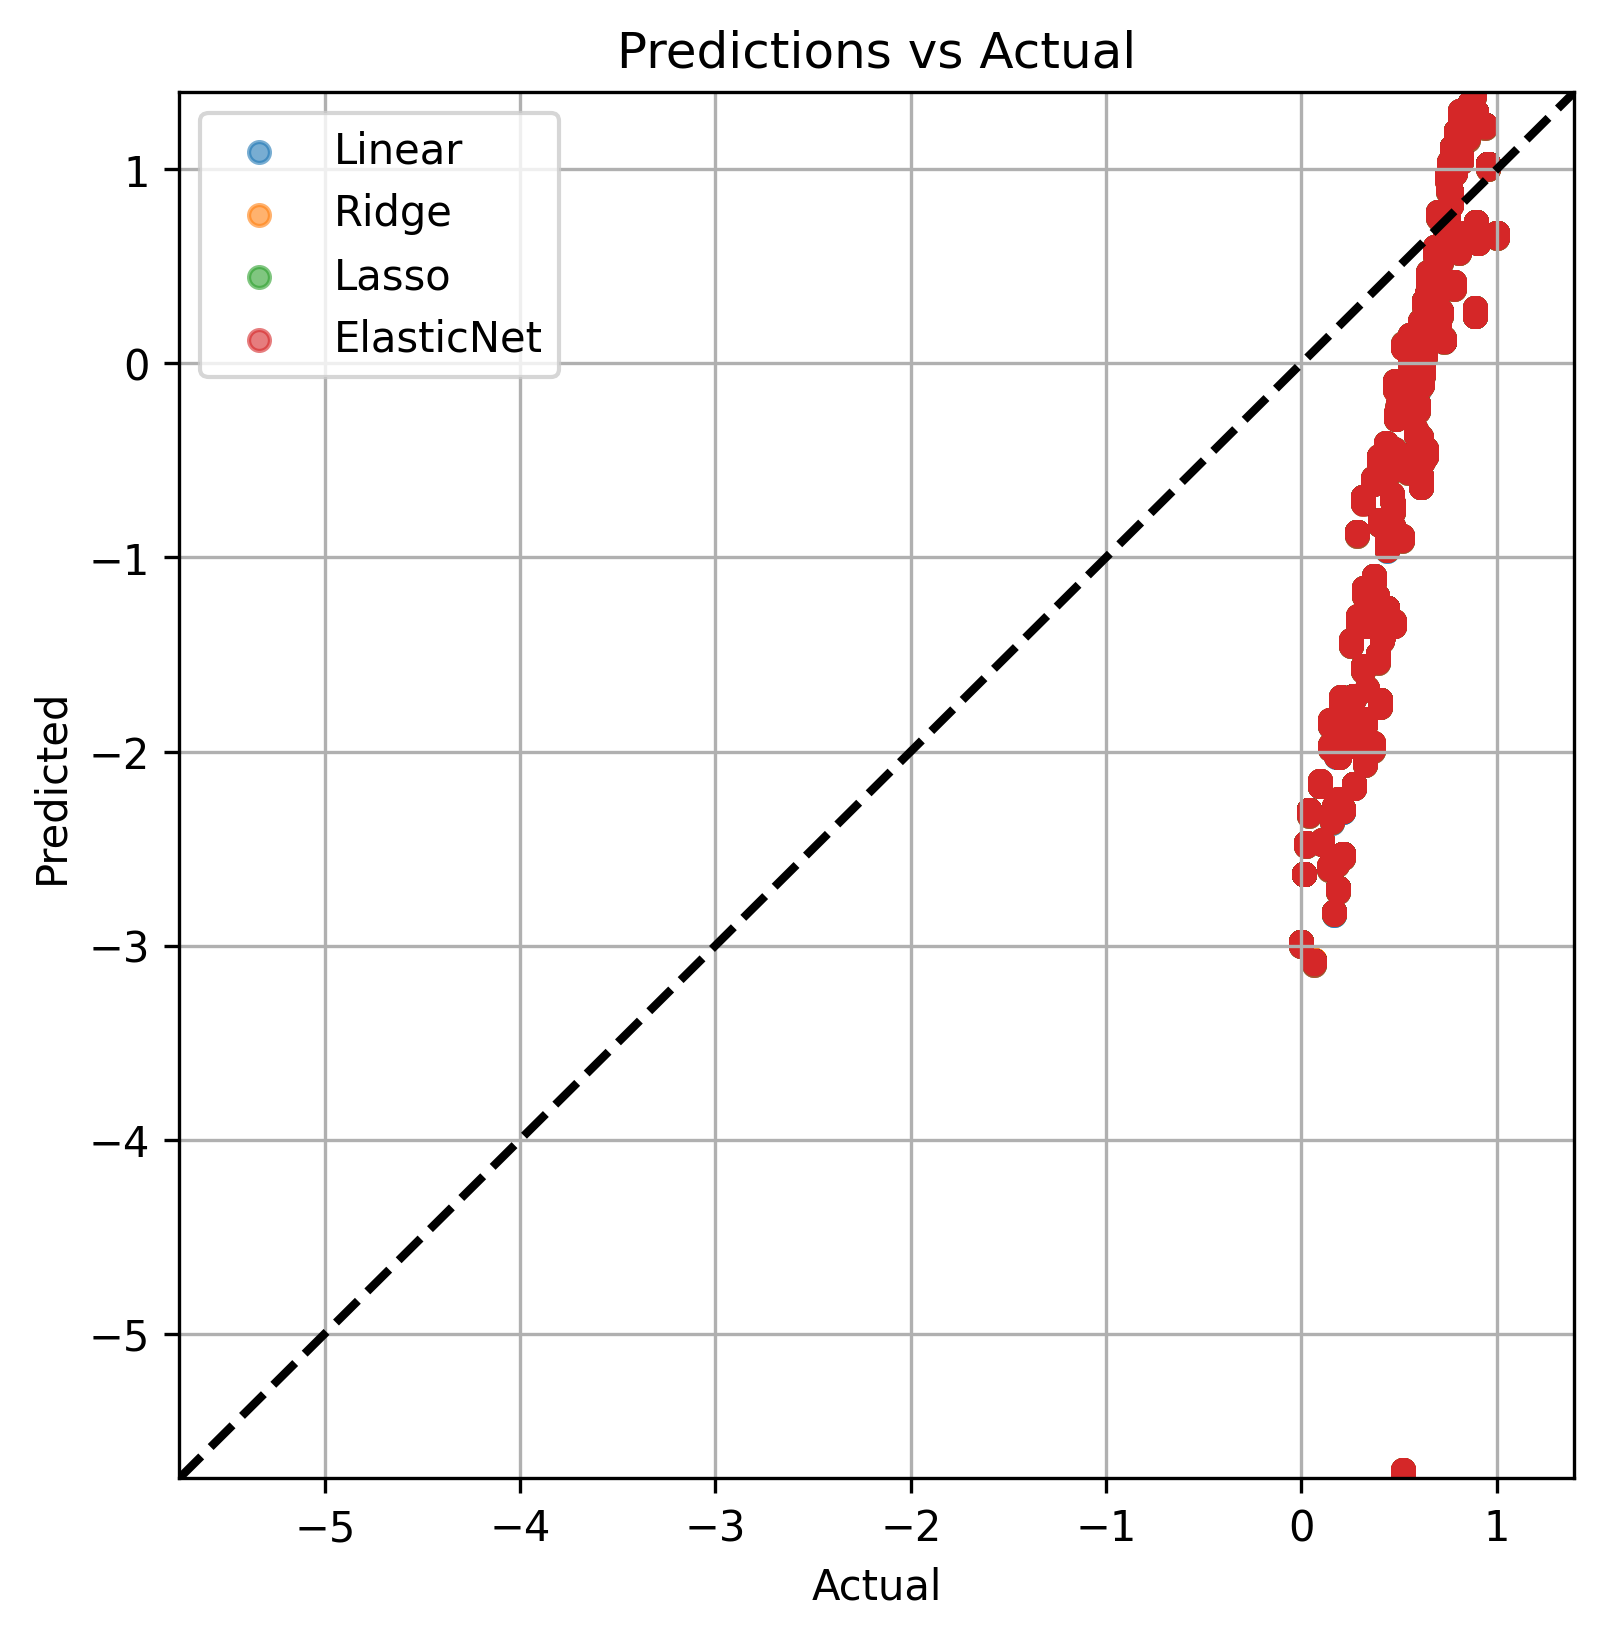

In [37]:
# Define RMSE function
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

# Fit models
linearRegression = LinearRegression().fit(X_train, y_train)
ridgeCV = RidgeCV(alphas=[0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80], cv=4).fit(X_train, y_train)
lassoCV = LassoCV(alphas=np.array([1e-5, 5e-5, 0.0001, 0.0005]), max_iter=int(5e4), cv=3).fit(X_train, y_train)
elasticNetCV = ElasticNetCV(alphas=np.array([1e-5, 5e-5, 0.0001, 0.0005]), 
                            l1_ratio=np.linspace(0.1, 0.9, 9),
                            max_iter=int(1e4)).fit(X_train, y_train)

# Now you can safely plot
f = plt.figure(figsize=(6, 6), dpi=300)
ax = plt.axes()

labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']
models = [linearRegression, ridgeCV, lassoCV, elasticNetCV]

# Plot actual vs predicted for each model
for mod, label in zip(models, labels):
    preds = mod.predict(X_test)
    ax.scatter(y_test, preds, label=label, alpha=0.6, s=25)

# Add 45-degree line (perfect prediction reference)
min_val = min(y_test.min(), *[mod.predict(X_test).min() for mod in models])
max_val = max(y_test.max(), *[mod.predict(X_test).max() for mod in models])
ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# Set axis limits and labels
ax.set_xlim([min_val, max_val])
ax.set_ylim([min_val, max_val])
ax.set_title("Predictions vs Actual")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.legend()
plt.grid(True)
plt.show()